# Topological Data Analysis (TDA) of PDGFR-β+ cells

## Preview

This notebook reports the topological data analysis (TDA) for PDGFR-β cells in specific brain regions (injured striatum and cortex, and perilesional tissue). Please note that this notebook runs Python code. 

**Parent dataset:** PDGFR-β(Td-tomato) ROIs imaged at 20x in different Z-planes. Images were z-projected for analysis. Samples are grouped at 0 (Sham), 3, 7, 14, and 30 days post-ischemia (DPI). The raw images and pre-processing scripts (if applicable) are available at the Zenodo repository (10.5281/zenodo.10553084) under the name `Widefield_20x_ROIs_Pdgfrb.zip`.

**Working dataset**: The `Raw_Data/Widefield_20x_ROIs_Pdgfrb/CellProfiler/Cells.csv`data frame containing the individual xy coordinates of PDGFR-β+ cells generated with CellProfiler [@stirling2021].

**Note:** This notebook runs using python code.

## Load required libraries

We import the required Python libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import csv

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle

import gudhi as gd
from gudhi import RipsComplex, plot_persistence_diagram
from gudhi import bottleneck_distance
from gudhi.wasserstein import wasserstein_distance

import itertools
from ripser import ripser
from persim import plot_diagrams
from random import choices
from scipy.spatial import ConvexHull

## Load and handle the dataset

We load the `Raw_Data/Widefield_20x_ROIs_Pdgfrb/CellProfiler/Cells.csv` dataset containing the cell coordinates. We handle the data to obtain and organize the relevant metadata from the file name.

In [2]:
# Load the dataset
file_path = 'Data_Raw/Widefield_20x_ROIs_Pdgfrb/CellProfiler/Cells.csv'  
data = pd.read_csv(file_path)

# Keep only the specified columns
data = data[['Location_Center_X', 'Location_Center_Y', 'FileName_Raw']]

# Define a function to parse the FileName_Raw column
def parse_filename(filename):
    parts = filename.split('_')
    # Extract the needed parts based on their position
    MouseID = parts[0]
    DPI = parts[1]
    Condition = parts[2]
    Lesion = parts[3]
    Region = parts[4]
    return MouseID, DPI, Condition, Lesion, Region

# Apply the function to the DataFrame
data[['MouseID', 'DPI', 'Condition', 'Lesion', 'Region']] = data.apply(lambda row: parse_filename(row['FileName_Raw']), axis=1, result_type='expand')

# Drop the FileName_Raw column
data.drop('FileName_Raw', axis=1, inplace=True)

# Reorder columns to move Location_Center_X and Location_Center_Y to the right
column_order = ['MouseID', 'DPI', 'Condition', 'Lesion', 'Region', 'Location_Center_X', 'Location_Center_Y']
data = data[column_order]

# Save the updated dataset to a new file
output_file_path = 'Data_Processed/Widefield_20x_ROIs_Pdgfrb/Widefield_20x_ROIs_Pdgfrb_Coords.csv'
data.to_csv(output_file_path, index=False)

print("Dataset updated and saved to:", output_file_path)


Dataset updated and saved to: Data_Processed/Widefield_20x_ROIs_Pdgfrb/Widefield_20x_ROIs_Pdgfrb_Coords.csv


## Calculate Vietoris-Rips Complex

In this section, we generate Vietoris-Rips complex for elucidating the topological features embedded within high-dimensional datasets. We construct the complexes from a finite set of points in a metric space to facilitate the analysis of their spatial relationships through a simplicial complex. The construction follows this scheme:

Let $S$ be a finite set of points in a metric space. The Vietoris-Rips complex, denoted as $ VR_{\epsilon}(S) $, is defined for a chosen distance threshold $ \epsilon $. The construction process is as follows:

1. **Vertices**: Each point in $ S $ is considered a vertex, or 0-simplex.

2. **Edges**: An edge, or 1-simplex, is formed between any pair of vertices $ (u, v) $ if the distance between them, denoted $ d(u, v) $, satisfies the condition $ d(u, v) \leq \epsilon $.

3. **Higher-Dimensional Simplices**: A $ k $-simplex is formed by a set of $ k+1 $ vertices if every pair of vertices within this set is connected by an edge. Mathematically, for a subset $ \{v_0, v_1, \ldots, v_k\} \subseteq S $, a $ k $-simplex exists if:

$$
   \forall i, j \in \{0, 1, \ldots, k\},\, d(v_i, v_j) \leq \epsilon
$$

4. **Complex Assembly**: The Vietoris-Rips complex $ VR_{\epsilon}(S) $ comprises all simplices, from 0-simplices to the highest dimension formed under the given threshold $ \epsilon $.

We load the cell coordinates to build the Vietoris-Rips complexes. We set `100` as the maximum filtration value to facilitate visualization.


In [4]:
# Load the organized dataset
data_path = 'Data_Processed/Widefield_20x_ROIs_Pdgfrb/Widefield_20x_ROIs_Pdgfrb_Coords.csv'  # Adjust this path as necessary
data = pd.read_csv(data_path)

# Group the dataset by MouseID and Region, then extract the point clouds
point_clouds_by_mouse_region = data.groupby(['MouseID', 'DPI', 'Region']).apply(lambda df: df[['Location_Center_X', 'Location_Center_Y']].values).to_dict()


def calculate_vietoris_rips_complex(point_cloud, max_dim, max_radius):
    """
    Calculate the Vietoris-Rips complex for a given point cloud.
    
    Parameters:
    - point_cloud: numpy array of shape (n_points, n_dimensions) representing the point cloud.
    - max_dim: int, the maximal dimension of the simplices in the Vietoris-Rips complex.
    - max_radius: float, the maximal radius for simplices in the Vietoris-Rips complex.
    
    Returns:
    - simplex_tree: a GUDHI SimplexTree object representing the Vietoris-Rips complex.
    """
    rips_complex = gd.RipsComplex(points=point_cloud, max_edge_length=max_radius)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dim)
    return simplex_tree

# Parameters for Vietoris-Rips complex calculation
max_dim = 3
max_radius = 100

# Calculate Vietoris-Rips complexes for each region of each animal
vietoris_rips_complexes = {}
for (mouse_id, dpi, region), point_cloud in point_clouds_by_mouse_region.items():
    key = (mouse_id, dpi, region)  # Use a tuple of MouseID and Region as the key
    vietoris_rips_complexes[key] = calculate_vietoris_rips_complex(point_cloud, max_dim, max_radius)

### Visualize and save Vietoris-Rips Complex

Once calculated, we save the images in a designated folder:

In [6]:
def plot_vietoris_rips_complex(point_cloud, simplex_tree, filename, save_dir, x_range=None, y_range=None):
    """
    Plot and save the Vietoris-Rips complex for a given 2D point cloud, with specified x and y axis ranges.

    Parameters:
    - point_cloud: numpy array of shape (n_points, 2) representing the 2D point cloud.
    - simplex_tree: a gudhi object representing the Vietoris-Rips complex.
    - filename: str, the name of the file to save the image.
    - save_dir: str, directory to save the image.
    - x_range: tuple, the range for the x-axis (optional).
    - y_range: tuple, the range for the y-axis (optional).
    """
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Plot points
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], c='black', s=20, alpha=0.8)
    
    # Plot edges
    edges = []
    for simplex in simplex_tree.get_skeleton(2):  # Get up to 2-simplices (edges)
        if len(simplex[0]) == 2:  # Edges
            p1, p2 = point_cloud[simplex[0][0]], point_cloud[simplex[0][1]]
            edges.append([p1, p2])
    lc = LineCollection(edges, colors='green', linewidths=1, alpha=0.7)
    ax.add_collection(lc)
    
    # Adjust plot settings
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    if x_range is not None:
        ax.set_xlim(x_range)
    if y_range is not None:
        ax.set_ylim(y_range)
    
    plt.tight_layout()
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(os.path.join(save_dir, f"{filename}.png"))
    plt.close()
    
    
# Directory to save the images
output_dir = "D:/Research/Stroke_PDGFR-B_Reactivity/Images/Widefield_20x-ROIs_Pdgfrb_TDA/VietorisRips_Static"  # Update this path
x_range = (0, 2000)  # Example x-axis range
y_range = (0, 1500)  # Example y-axis range
aspect_ratio = 'auto'  # Adjust this based on your data or preferences


# Assuming vietoris_rips_complexes and point_clouds_by_mouse have been computed accordingly
for (mouse_id, dpi, region), simplex_tree in vietoris_rips_complexes.items():
    filename = f"{mouse_id}_{dpi}_{region}_VietorisRips"
    point_cloud = point_clouds_by_mouse_region[(mouse_id, dpi, region)]
    plot_vietoris_rips_complex(point_cloud, simplex_tree, filename, output_dir, x_range, y_range)


### Visualize and save Vietoris-Rips Complex (animated)

We created animated Vietoris-rips for illustration in the scientific article. We save animations with a maximum of `300` filtration value.

In [ ]:
def animate_vietoris_rips_mp4(point_cloud, simplex_tree, filename, save_dir, max_radius, step_size=1):
    """
    Create an .mp4 animation illustrating the growth of the Vietoris-Rips complex for 2D data.
    """
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], c='black', s=20, alpha=0.8)

    # Function to update the plot for each frame
    def update(threshold):
        ax.cla()  # Clear current plot details
        ax.scatter(point_cloud[:, 0], point_cloud[:, 1], c='black', s=10, alpha=0.7)
        edges = []
        for simplex in simplex_tree.get_skeleton(2):
            if simplex[1] <= threshold:
                if len(simplex[0]) == 2:  # Edges
                    p1, p2 = point_cloud[simplex[0][0]], point_cloud[simplex[0][1]]
                    edges.append([p1, p2])
        lc = LineCollection(edges, colors='green', alpha=0.7)
        ax.add_collection(lc)
        
        ax.set_title(f"Threshold: {threshold:.2f}", fontsize=20)
        ax.set_xlabel('X', fontsize=20, labelpad=15)
        ax.set_ylabel('Y', fontsize=20, labelpad=15)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.axis('equal')

    ani = FuncAnimation(fig, update, frames=np.arange(0, max_radius, step_size), blit=False)
    ani_file = os.path.join(save_dir, f"{filename}_Animation.mp4")
    ani.save(ani_file, writer='ffmpeg', fps=2, extra_args=['-vcodec', 'libx264'])

    plt.close()
    return ani_file  # Return the file path of the saved animation

# Example usage
output_dir = "D:/Research/Stroke_PDGFR-B_Reactivity/Images/Widefield_20x-ROIs_Pdgfrb_TDA/VietorisRips_Animated"  
max_radius = 300  # Adjust as necessary
step_size = 20  # Adjust as necessary

for (mouse_id, dpi, region), simplex_tree in vietoris_rips_complexes.items():
    filename = f"{mouse_id}_{dpi}_{region}_VietorisRips"
    point_cloud = point_clouds_by_mouse_region[(mouse_id, dpi, region)]
    ani_file = animate_vietoris_rips_mp4(point_cloud, simplex_tree, filename, output_dir, max_radius, step_size)
    print(f"Saved animation: {ani_file}")

## Generate point clouds

We generate point clouds and store them as individual files to use along the TDA. First, we load again the dataset in case is not present in the environment. 

In [8]:
# Load your dataset
data_path = 'Data_Processed/Widefield_20x_ROIs_Pdgfrb/Widefield_20x_ROIs_Pdgfrb_Coords.csv'  
data = pd.read_csv(data_path)

# Group data by MouseID, Region, and DPI
point_clouds_by_group = data.groupby(['MouseID', 'DPI', 'Region',]).apply(
    lambda df: df[['Location_Center_X', 'Location_Center_Y']].values
).to_dict()

Next, we verify the structire of the data to make sure is grouped as intented. 

In [9]:
if not point_clouds_by_group:
    print("The point_clouds_by_group dictionary is empty.")
else:
    print("Point clouds loaded:", len(point_clouds_by_group))
    
    # Inspect the first few items to ensure they're structured correctly
for key, value in list(point_clouds_by_group.items())[:5]:
    print(key, value.shape)

Point clouds loaded: 143
('Td012', '7D', 'Ctx') (374, 2)
('Td012', '7D', 'Peri') (166, 2)
('Td012', '7D', 'Str') (186, 2)
('Td014', '7D', 'Ctx') (198, 2)
('Td014', '7D', 'Peri') (177, 2)


Then, we save point clouds as .npy files (Numpy array) in a designated folder

In [10]:
def save_point_clouds_as_npy(point_clouds_by_group, data_directory):
    """
    Saves point clouds to .npy files in the specified directory.
    
    Parameters:
        point_clouds_by_group (dict): Dictionary with keys as identifiers 
            (e.g., ('MouseID', 'Region', 'DPI')) and values as numpy arrays representing point clouds.
        data_directory (str): Path to the directory where .npy files will be saved.
    """
    # Ensure the directory exists
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)
    
    # Iterate through the point clouds and save each as an .npy file
    for identifier, point_cloud in point_clouds_by_group.items():
        # Create a filename from the identifier
        filename = "_".join(identifier) + ".npy"
        filepath = os.path.join(data_directory, filename)
        np.save(filepath, point_cloud)
    
    print("Point clouds saved as .npy files.")

data_directory = r"PointClouds/Widefield_20x_ROIs_Pdgfrb/"

# Call the function with your data and desired save location
save_point_clouds_as_npy(point_clouds_by_group, data_directory)

Point clouds saved as .npy files.


## Computation of persistent homology

In this section, we analize the generated point clouds using persisten homology. We use the same data the `process_and_visualize_persistence` function to process the same dataset containing xy coordinates of PDGFR-B+ cells. We compute persistent diagrams using the `ripster` libary. These diagrams capture the birth and death of topological features (like loops or voids) in the data as one varies a filtering parameter. The persistence diagrams are then visualized using the `persim` library. 

This analysis provide insights into the topological structure of the data, indicating features that persist across scales. In TDA, features that persist longer (i.e., have a wider gap between birth and death) are deemed more significant as they represent genuine structures rather than noise. Then, we save each persistence diagram as a .png image.

### Compute persistence diagrams

We compute persistence diagrams and save then as .npy file for further analysis and as .png images for visualization

In [33]:
# Disable LaTeX usage in matplotlib
plt.rcParams['text.usetex'] = False

def process_npy_for_persistence_diagrams(data_directory, save_directory, save_diag_directory, img_size=(6, 6), x_range=None, y_range=None):
    """
    Batch process .npy files (containing point clouds) to compute, visualize, and save persistence diagrams.
    """
    # Ensure save directories exist
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    if not os.path.exists(save_diag_directory):
        os.makedirs(save_diag_directory)
    
    # List all .npy files in the data directory
    npy_files = [f for f in os.listdir(data_directory) if f.endswith('.npy')]
    
    for file in npy_files:
        # Load the point cloud from the .npy file
        points_array = np.load(os.path.join(data_directory, file))
        
        # Compute the persistence diagrams using Ripser
        diagrams = ripser(points_array, maxdim=1)['dgms']
        
        # Save each dimension's persistence diagram as a separate .npy file
        for dim, diag in enumerate(diagrams):
            diag_filename = os.path.splitext(file)[0] + f"_persistence_diag_dim{dim}.npy"
            np.save(os.path.join(save_diag_directory, diag_filename), diag)
        
        # Visualize and save the persistence diagrams
        fig, ax = plt.subplots(figsize=img_size)
        plot_diagrams(diagrams, show=False, ax=ax)
        ax.set_title("")
        ax.set_xlabel('Birth', fontsize=25)
        ax.set_ylabel('Death', fontsize=25)
        ax.tick_params(axis='both', which='major', labelsize=25)
        
        # Optionally adjust the legend
        legend = ax.legend()
        if legend:
            for label in legend.get_texts():
                label.set_fontsize(20)
        
        plt.tight_layout()
        
        if x_range is not None:
            ax.set_xlim(x_range)
        if y_range is not None:
            ax.set_ylim(y_range)
        
        # Save the figure
        filename = os.path.splitext(file)[0] + "_persistence_diagram.png"
        fig.savefig(os.path.join(save_directory, filename))
        plt.close()
    
    print(f"Persistence diagrams saved to {save_directory}.")
    print(f"Persistence diagrams data saved to {save_diag_directory}.")

# Paths to your directories
data_directory = r"PointClouds/Widefield_20x_ROIs_Pdgfrb/"
save_directory = r"D:/Research/Stroke_PDGFR-B_Reactivity/Images/Widefield_20x-ROIs_Pdgfrb_TDA/PersistenceDiagrams"
save_diag_directory = r"Data_Raw/Widefield_20x_ROIs_Pdgfrb/PersistenceDiagrams/"

#x_range = (0, 500)  
#y_range = (0, 500) 

# Call the function to process, visualize, and save persistence diagrams
process_npy_for_persistence_diagrams(data_directory, save_directory, save_diag_directory)


Persistence diagrams saved to D:/Research/Stroke_PDGFR-B_Reactivity/Images/Widefield_20x-ROIs_Pdgfrb_TDA/PersistenceDiagrams.
Persistence diagrams data saved to Data_Raw/Widefield_20x_ROIs_Pdgfrb/PersistenceDiagrams/.


## Calculate Betti curves for the persistent diagrams

Now, we use Betti curves to encapsulate the evolution of topological features across a spectrum of different scales. We can visualize how connected components ($\beta_0$) and loops ($\beta_1$) change as a function of a scaling parameter, 
The Betti curve for each dimension is a function mapping the scaling parameter to the corresponding Betti number (not shown here). 

Here, we compute Betti curves in different chunks for 0D-Homology and 1D-homology. To eliminte bias for the number of connected components, we normalize 0D-hoology Betti curves bubt not 1D-homology (loops). We calculate the Betti curvas by region and plot different lines for each DPI. 

### Betti curves for 0D homology

Saved Betti-0 curve plot for Ctx at D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Plots/Widefield_20x_ROIs_pdgfrb_TDA\Betti0_Curves_Ctx.png


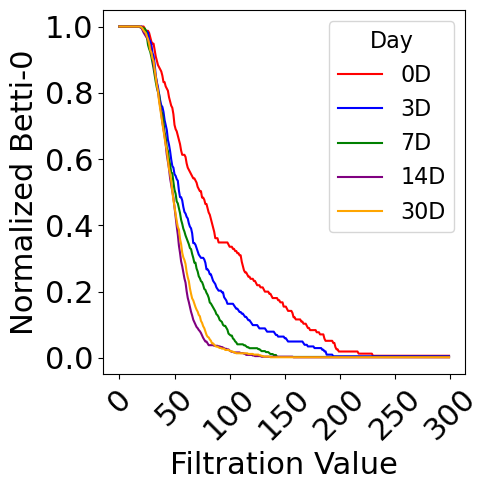

Saved Betti-0 curve plot for Peri at D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Plots/Widefield_20x_ROIs_pdgfrb_TDA\Betti0_Curves_Peri.png


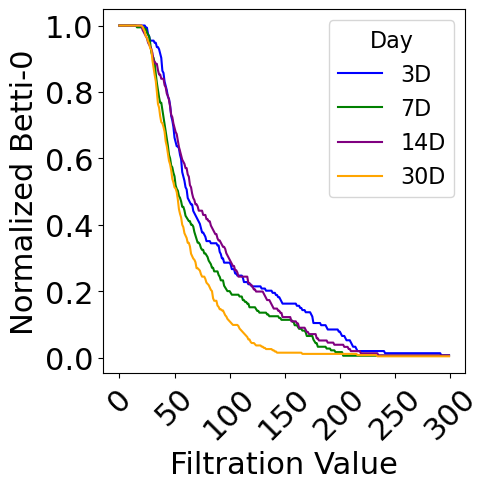

Saved Betti-0 curve plot for Str at D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Plots/Widefield_20x_ROIs_pdgfrb_TDA\Betti0_Curves_Str.png


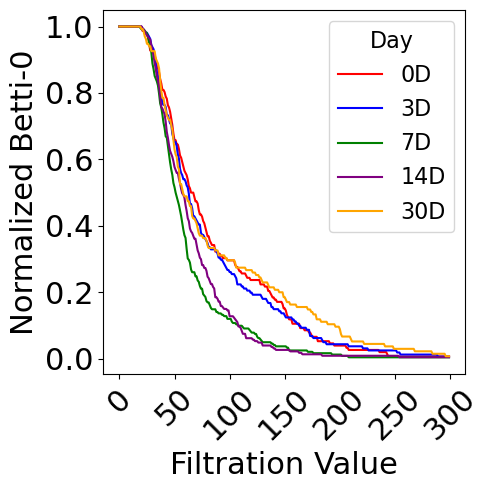

In [12]:
def load_persistence_diagrams(dim0_path):
    files = [f for f in os.listdir(dim0_path) if 'dim0' in f]
    data = {}
    for file in files:
        parts = file.split('_')
        day, region = parts[1], parts[2]
        diagram = np.load(os.path.join(dim0_path, file))
        key = (day, region)
        data[key] = diagram
    return data

def compute_betti_0_curve(persistence_diagram, max_filtration_value, n_steps):
    betti_0_curve = []
    filtration_values = np.linspace(0, max_filtration_value, n_steps)
    for value in filtration_values:
        betti_0 = sum(1 for point in persistence_diagram if point[0] <= value and (point[1] > value or point[1] == float('inf')))
        betti_0_curve.append(betti_0)

    # Normalize the curve to start at 1
    if betti_0_curve[0] != 0:  # Ensure there is no division by zero
        initial_value = betti_0_curve[0]
        normalized_betti_0_curve = [b / initial_value for b in betti_0_curve]
    else:
        # Handle the case where the initial value is 0
        normalized_betti_0_curve = betti_0_curve

    return normalized_betti_0_curve

dim0_path = "Data_Raw/Widefield_20x_ROIs_Pdgfrb/PersistenceDiagrams/"
dim0_data = load_persistence_diagrams(dim0_path)

n_steps = 300
max_filtration_value = 300
betti_0_curves = {key: compute_betti_0_curve(diagram, max_filtration_value, n_steps) for key, diagram in dim0_data.items()}

# Aggregating Betti curves by region
aggregated_curves_by_region_0 = {}
for (day, region), curve in betti_0_curves.items():
    if region not in aggregated_curves_by_region_0:
        aggregated_curves_by_region_0[region] = {}
    aggregated_curves_by_region_0[region][day] = curve

def plot_aggregated_betti_curves_0(aggregated_curves_by_region_0, save_directory):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    
    days_order = ['0D', '3D', '7D', '14D', '30D']
    day_colors = {
        '0D': 'red',
        '3D': 'blue',
        '7D': 'green',
        '14D': 'purple',
        '30D': 'orange'
    }

    for region, curves in aggregated_curves_by_region_0.items():
        plt.figure(figsize=(5, 5))
        for day in days_order:
            if day in curves:
                plt.plot(curves[day], label=day, color=day_colors[day])
        
        plt.xlabel("Filtration Value", fontsize=22)
        plt.ylabel("Normalized Betti-0", fontsize=22)
        plt.xticks(fontsize=22, rotation=45)
        plt.yticks(fontsize=22)
        leg = plt.legend(title="Day", fontsize=16)
        plt.setp(leg.get_title(), fontsize=16)
        plt.tight_layout()

        plot_path = os.path.join(save_directory, f"Betti0_Curves_{region}.png")
        plt.savefig(plot_path)
        print(f"Saved Betti-0 curve plot for {region} at {plot_path}")
        
        plt.show()
        plt.close()

save_directory = "D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Plots/Widefield_20x_ROIs_pdgfrb_TDA"
plot_aggregated_betti_curves_0(aggregated_curves_by_region_0, save_directory)

### Betti curves for 1D homology

Now, we calculate the Betti curves for 1D homoogy. 


Saved Betti-1 curve plot for Ctx at Plots/Widefield_20x_ROIs_pdgfrb_TDA/Betti1_Curves_Ctx.png


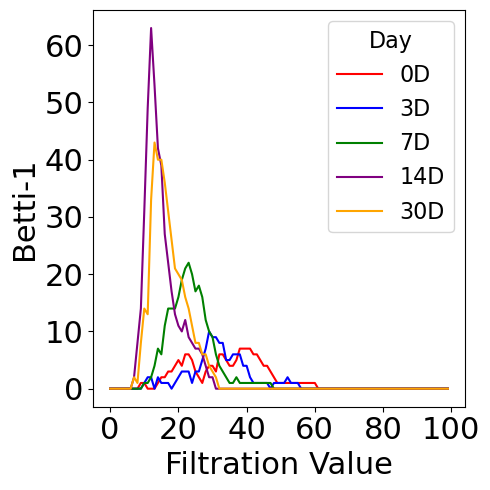

Saved Betti-1 curve plot for Peri at Plots/Widefield_20x_ROIs_pdgfrb_TDA/Betti1_Curves_Peri.png


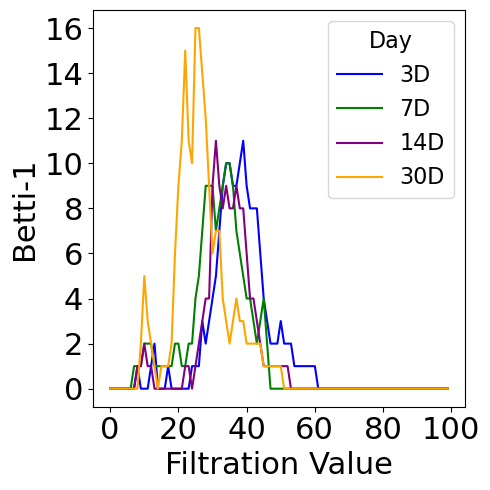

Saved Betti-1 curve plot for Str at Plots/Widefield_20x_ROIs_pdgfrb_TDA/Betti1_Curves_Str.png


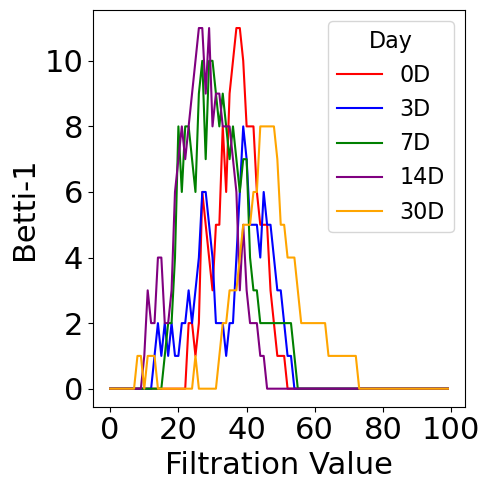

In [19]:
def load_persistence_diagrams(dim1_path):
    files = [f for f in os.listdir(dim1_path) if 'dim1' in f]
    data = {}
    for file in files:
        parts = file.split('_')
        day, region = parts[1], parts[2]
        diagram = np.load(os.path.join(dim1_path, file))
        key = (day, region)
        data[key] = diagram
    return data

dim1_path = "Data_Raw/Widefield_20x_ROIs_Pdgfrb/PersistenceDiagrams/"
dim1_data = load_persistence_diagrams(dim1_path)


def compute_betti_1_curve(persistence_diagram, max_filtration_value, n_steps):
    betti_1_curve = []
    filtration_values = np.linspace(0, max_filtration_value, n_steps)
    for value in filtration_values:
        betti_1 = sum(1 for point in persistence_diagram if point[0] <= value and (point[1] > value or point[1] == float('inf')))
        betti_1_curve.append(betti_1)
    return betti_1_curve

n_steps = 100
max_filtration_value = 700
betti_1_curves = {key: compute_betti_1_curve(diagram, max_filtration_value, n_steps) for key, diagram in dim1_data.items()}

# Aggregating Betti curves by region
aggregated_curves_by_region_1 = {}
for (day, region), curve in betti_1_curves.items():
    if region not in aggregated_curves_by_region_1:
        aggregated_curves_by_region_1[region] = {}
    aggregated_curves_by_region_1[region][day] = curve
    
    
def plot_aggregated_betti_curves_1(aggregated_curves_by_region_1, save_directory):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    
    days_order = ['0D', '3D', '7D', '14D', '30D']
    day_colors = {
        '0D': 'red',
        '3D': 'blue',
        '7D': 'green',
        '14D': 'purple',
        '30D': 'orange'
    }

    for region, curves in aggregated_curves_by_region_1.items():
        plt.figure(figsize=(5, 5))  # Adjust figure size as needed
        for day in days_order:
            if day in curves:
                plt.plot(curves[day], label=day, color=day_colors[day])
        plt.xlabel("Filtration Value", fontsize=22)
        plt.ylabel("Betti-1", fontsize=22)
        plt.xticks(fontsize=22)  # Increase tick label size
        plt.yticks(fontsize=22)  # Increase tick label size
        leg = plt.legend(title="Day", fontsize=16)
        plt.setp(leg.get_title(), fontsize=16)  # Increase legend title size
        plt.tight_layout()

        # Save the plot before calling plt.show()
        plot_path = os.path.join(save_directory, f"Betti1_Curves_{region}.png")
        plt.savefig(plot_path)
        print(f"Saved Betti-1 curve plot for {region} at {plot_path}")
        
        # Show the plot inline
        plt.show()
        plt.close()

# Specify the directory where you want to save the plots
save_directory = "Plots/Widefield_20x_ROIs_pdgfrb_TDA/"

# Call the function with your aggregated Betti curves and the save directory
plot_aggregated_betti_curves_1(aggregated_curves_by_region_1, save_directory)     
    

## Calculate Bottleneck distances

Now, we use the bottleneck distance to compare the persistent diagrams. Given two persistence diagrams D1 and D2, the bottleneck distance measures the minimum amount one needs to move points in D1 to match points in D2 and vice versa, such that the worst-case (or maximum) movement is minimized. Mathematically, the bottleneck distance is defined as:

$$
\text{bottleneck}(D_1, D_2) = \inf_{\phi: D_1 \to D_2} \sup_{x \in D_1} ||x - \phi(x)||_{\infty}
$$

Performing bootstrapping, we estimate the distribution of the bottleneck distances by resampling with replacement from the data. Then, we repeat the sampling 1000 times to compute 95% confidence intervals.

In our analysis, we load organize persistence diagrams corresponding to various days, regions, and proteins from designated file paths. The diagrams are gouped based on the mentioned factors and perform specific pairwise day comparisons. We use bootstrap iterations to obtain bottleneck distances between the persistence diagrams of two distinct days, representing the topological disparity between them. These results are stored in a CSV file and the visualized as a heat map.

### Load persistance diagrams

We load the persistent diagrams by **0D** or **1D** homology Interchangeably. From each diagram, we obtain the grouping metadata and perform the bootstraping procedure to calculate Bottlenecks distances. Please note this procedure is expensive and make take hours to complete. 

**Note:** To shift focus to dimension 1 persistence diagrams, one can replace 'dim0.npy' with 'dim1.npy' in the code.

In [14]:
### To calculate dimension 1, change the dim0 to dim1

# Define the path to persistence diagrams
path = "Data_Raw/Widefield_20x_ROIs_Pdgfrb/PersistenceDiagrams/"

# Load .npy files for dimension 1 diagrams
files = [f for f in os.listdir(path) if f.endswith('dim1.npy')]

# Organize data into a nested dictionary {day: {region: [diagrams, ...], ...}, ...}
data = {}
for file in files:
    # Extract information from the filename
    parts = file.split("_")
    day, region = parts[1], parts[2]
    # Load the persistence diagram
    diagram = np.load(os.path.join(path, file))
    # Initialize day if not already in data
    if day not in data:
        data[day] = {}
    # Append the diagram to the correct day and region
    data[day].setdefault(region, []).append(diagram)

Next, we verifying the loaded data structure

In [15]:
for day in data:
    print(f"Day: {day}")
    for region in data[day]:
        num_diagrams = len(data[day][region])
        print(f"  Region: {region}, Number of diagrams: {num_diagrams}")
        # Optionally, print out some details of the first diagram as an example
        if num_diagrams > 0:
            example_diagram = data[day][region][0]
            print(f"    Example diagram size: {example_diagram.shape}")
            print(f"    Example diagram content (first few pairs): {example_diagram[:5]}")
        else:
            print("    No diagrams for this region and day.")
    print("\n")  

Day: 7D
  Region: Ctx, Number of diagrams: 13
    Example diagram size: (84, 2)
    Example diagram content (first few pairs): [[229.65971375 345.76617432]
 [203.44630432 216.10943604]
 [198.74375916 227.59474182]
 [186.15898132 190.30844116]
 [185.2010498  187.16305542]]
  Region: Peri, Number of diagrams: 13
    Example diagram size: (31, 2)
    Example diagram content (first few pairs): [[354.39553833 402.50540161]
 [324.65130615 337.05899048]
 [311.98751831 324.07434082]
 [257.42388916 313.76132202]
 [256.47439575 257.78848267]]
  Region: Str, Number of diagrams: 13
    Example diagram size: (25, 2)
    Example diagram content (first few pairs): [[301.1104126  398.73208618]
 [287.04321289 287.95681763]
 [263.06341553 285.93179321]
 [255.86216736 259.22183228]
 [245.90634155 247.80302429]]


Day: 14D
  Region: Ctx, Number of diagrams: 10
    Example diagram size: (186, 2)
    Example diagram content (first few pairs): [[187.52854919 189.28244019]
 [162.97486877 173.46350098]
 [154.7

### Computing distances by boostraping and saving metrics

Now we perform the analysis between persistence diagrams for specified pairwise day comparisons.First, we define the specific pairwise day comparisons of interest (0D-3D, 3D-7D, 7D-14D, 14D-30D) and extract unique days, regions, and proteins from the data. For each unique combination of Region and Protein, we extract persistence diagrams associated with each day. The region Peri (Perilesional) does not contain information from 0D. Therefore, we skip to the next iteration. 

In [ ]:
# Define the specified pairwise day comparisons
day_pairs = [("0D", "3D"), ("3D", "7D"), ("7D", "14D"), ("14D", "30D")]

# Extract unique days and regions from the data
unique_days = set(data.keys())
unique_regions = set(region for day in data for region in data[day])

results = []

# Define number of bootstrap replications
num_replications = 1000

# For each unique combination of Day and Region
for region in unique_regions:
    # Perform the specified pairwise comparison of diagrams from different days
    for day1, day2 in day_pairs:
        bootstrap_distances = []

        for _ in range(num_replications):
            # Randomly sample diagrams from day1 and day2 with replacement
            bootstrap_sample1 = choices(data[day1].get(region, []), k=len(data[day1].get(region, [])))
            bootstrap_sample2 = choices(data[day2].get(region, []), k=len(data[day2].get(region, [])))

            # Compute pairwise bottleneck distances for the bootstrap samples
            distances = [bottleneck_distance(diag1, diag2) for diag1 in bootstrap_sample1 for diag2 in bootstrap_sample2 if diag1.size and diag2.size]

            # Only proceed if there are distances to calculate
            if distances:
                # Compute the median distance for this bootstrap replication
                bootstrap_distances.append(np.median(distances))

        # Skip if no distances were calculated
        if not bootstrap_distances:
            continue

        # Compute metrics
        median_distance = np.median(bootstrap_distances)
        confidence_lower = np.percentile(bootstrap_distances, 2.5)
        confidence_upper = np.percentile(bootstrap_distances, 97.5)

        # Store the results
        results.append((day1, day2, region, median_distance, confidence_lower, confidence_upper))

# Define the results path and save results to CSV
results_path = "Data_Processed//Widefield_20x_ROIs_Pdgfrb/"

# Change the name for 1D
csv_file = os.path.join(results_path, "Widefield_20x_ROIs_Pdgfrb_Bottleneck_0d.csv")

with open(csv_file, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    # Write header
    csvwriter.writerow(['Day1', 'Day2', 'Region', 'Median Bottleneck Distance', '95% CI Lower', '95% CI Upper'])
    # Write the results
    for row in results:
        csvwriter.writerow(row)

print(f"Bootstrap results saved to {csv_file}.")


### Visualization of bottleneck distances by heatmap

We vislauzie the bottleneck distances by heatmap using seaborn:

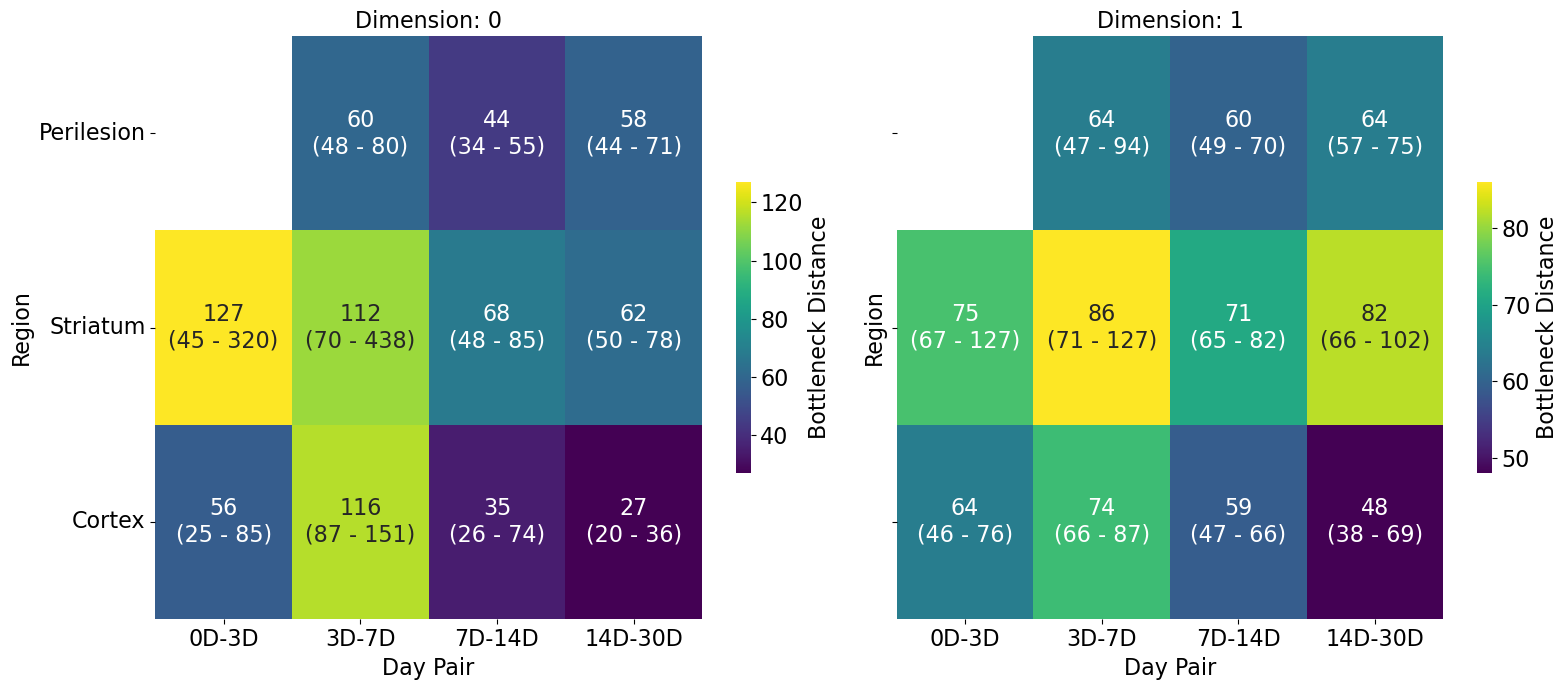

In [17]:
# Load CSV data for 0-dimension and 1-dimension homology
csv_path_dim0 = os.path.join("Data_Processed/Widefield_20x_ROIs_Pdgfrb/Widefield_20x_ROIs_Pdgfrb_Bottleneck_0d.csv")
csv_path_dim1 = os.path.join("Data_Processed/Widefield_20x_ROIs_Pdgfrb/Widefield_20x_ROIs_Pdgfrb_Bottleneck_1d.csv")
data_dim0 = pd.read_csv(csv_path_dim0)
data_dim1 = pd.read_csv(csv_path_dim1)

# Assuming the structure of your CSV files matches the expected columns

# Define label mappings and structure
regions = ["Peri", "Str", "Ctx"]
region_labels = ["Perilesion", "Striatum", "Cortex"]
days = ["0D-3D", "3D-7D", "7D-14D", "14D-30D"]
dimensions = ["dim0", "dim1"]  # Representing 0-dimension and 1-dimension homology

# Initialize an empty dictionary to store heatmap data for each dimension
heatmap_data = {dim: pd.DataFrame(index=regions, columns=days) for dim in dimensions}
heatmap_annotations = {dim: pd.DataFrame(index=regions, columns=days) for dim in dimensions}

# Function to populate matrices with data from CSV
def populate_heatmap(data, dim):
    for _, row in data.iterrows():
        day_pair, region, median_distance, lower, upper = row['Day1']+'-'+row['Day2'], row['Region'], round(row['Median Bottleneck Distance']), round(row['95% CI Lower']), round(row['95% CI Upper'])
        if region in regions:
            heatmap_data[dim].loc[region, day_pair] = median_distance
            # Adjust annotation format here to round and remove decimals
            annotation = f"{median_distance}\n({lower} - {upper})"
            heatmap_annotations[dim].loc[region, day_pair] = annotation

populate_heatmap(data_dim0, "dim0")
populate_heatmap(data_dim1, "dim1")

# Convert the data to numeric and handle NaN values
for dim in dimensions:
    heatmap_data[dim] = heatmap_data[dim].astype(float)
    heatmap_data[dim].fillna(-1, inplace=True)  # Fill NaN values with -1 for missing data

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
for ax, dim in zip(axes, dimensions):
    sns.heatmap(heatmap_data[dim], annot=heatmap_annotations[dim], cmap='viridis', ax=ax,
                cbar_kws={'label': 'Bottleneck Distance', 'shrink': 0.5},
                mask=(heatmap_data[dim] == -1), fmt="", annot_kws={"size": 16})
    ax.set_title(f"Dimension: {dim[-1]}", fontsize=16)
    ax.set_xlabel("Day Pair", fontsize=16)
    ax.set_ylabel("Region", fontsize=16)
    ax.set_yticklabels(region_labels, fontsize=16, rotation=0)
    ax.tick_params(axis='x', labelsize=16)

    # Adjust colorbar label size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_ylabel('Bottleneck Distance', fontsize=16)

plt.tight_layout()
plt.show()

# Update the output directory path for saving individual images
output_dir = "Plots/Widefield_20x_ROIs_pdgfrb_TDA"

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save individual heatmap images for each dimension
for dim in dimensions:
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(heatmap_data[dim], annot=heatmap_annotations[dim], cmap='viridis', ax=ax,
                cbar_kws={'label': 'Bottleneck Distance'},
                mask=(heatmap_data[dim] == -1), fmt="s")
    ax.set_title(f"Bottleneck Distances (Dimension: {dim[-1]})", fontsize=16)
    ax.set_xlabel("Day Pair", fontsize=16)
    ax.set_ylabel("Region", fontsize=16)
    ax.set_yticklabels(region_labels, fontsize=16)
    ax.tick_params(axis='x', labelsize=16)
    
    # Adjust colorbar label size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_ylabel('Bottleneck Distance', fontsize=16)
    
    plt.tight_layout()

    # Save the figure
    fig.savefig(os.path.join(output_dir, f"Bottleneck_Heatmap_{dim}.png"))
    plt.close(fig)


In the graphs, we observed the **median** Bottleneck distances and 95% onfidence intervals for day pairs.

## Calculate Wasserstain distances

We calculate as well Wasserstein distances, also known as the Earth Mover's or Kantorovich-Rubinstein distance. This metric comprises all possible pairs of points between the two diagrams and weighs them by their distance. This represents the minimum "effort" or "cost" to transform one persistence diagram into another. 

### Load persistance diagrams

**Noe** Load the data from the Bottleneck distances section. Please make sure to change dim0 or dim1 as needed. 

### Compute Wasserstein distances by boostrapping and saving metrics

In [ ]:
# Define the specified pairwise day comparisons
day_pairs = [("0D", "3D"), ("3D", "7D"), ("7D", "14D"), ("14D", "30D")]

# Extract unique days and regions from the data
unique_days = set(data.keys())
unique_regions = set(region for day in data for region in data[day])

results = []

# Define number of bootstrap replications
num_replications = 1000

# For each unique combination of Day and Region
for region in unique_regions:
    # Perform the specified pairwise comparison of diagrams from different days
    for day1, day2 in day_pairs:
        if day1 in data and day2 in data and region in data[day1] and region in data[day2]:
            bootstrap_distances = []

            for _ in range(num_replications):
                # Randomly sample diagrams from day1 and day2 with replacement
                bootstrap_sample1 = choices(data[day1].get(region, []), k=len(data[day1].get(region, [])))
                bootstrap_sample2 = choices(data[day2].get(region, []), k=len(data[day2].get(region, [])))

                # Compute pairwise Wasserstein distances for the bootstrap samples
                distances = [wasserstein_distance(diag1, diag2, order=2) for diag1 in bootstrap_sample1 for diag2 in bootstrap_sample2 if diag1.size and diag2.size]

                # Only proceed if there are distances to calculate
                if distances:
                    # Compute the median distance for this bootstrap replication
                    bootstrap_distances.append(np.median(distances))

            # Skip if no distances were calculated
            if not bootstrap_distances:
                continue

            # Compute metrics
            median_distance = np.median(bootstrap_distances)
            confidence_lower = np.percentile(bootstrap_distances, 2.5)
            confidence_upper = np.percentile(bootstrap_distances, 97.5)

            # Store the results
            results.append((day1, day2, region, median_distance, confidence_lower, confidence_upper))

# Define the results path and save results to CSV
results_path = "D:/Research/Stroke_PDGFR-B_Reactivity/Pdgfrb_Reactivity_DataAnalysis/Stroke_Pdgfrb_Reactivity/Data_Raw/Widefield_20x_ROIs_Pdgfrb/"
csv_file = os.path.join(results_path, "Widefield_20x_ROIs_Pdgfrb_Wasserstein_1d.csv")

with open(csv_file, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    # Write header
    csvwriter.writerow(['Day1', 'Day2', 'Region', 'Median Wasserstein Distance', '95% CI Lower', '95% CI Upper'])
    # Write the results
    for row in results:
        csvwriter.writerow(row)

print(f"Wasserstein distance bootstrap results saved to {csv_file}.")


###  Visualization of Wasserstein distances by heatmap

We plot the calculated Wasserstein distances and save corresponding plots in the designated folder. 

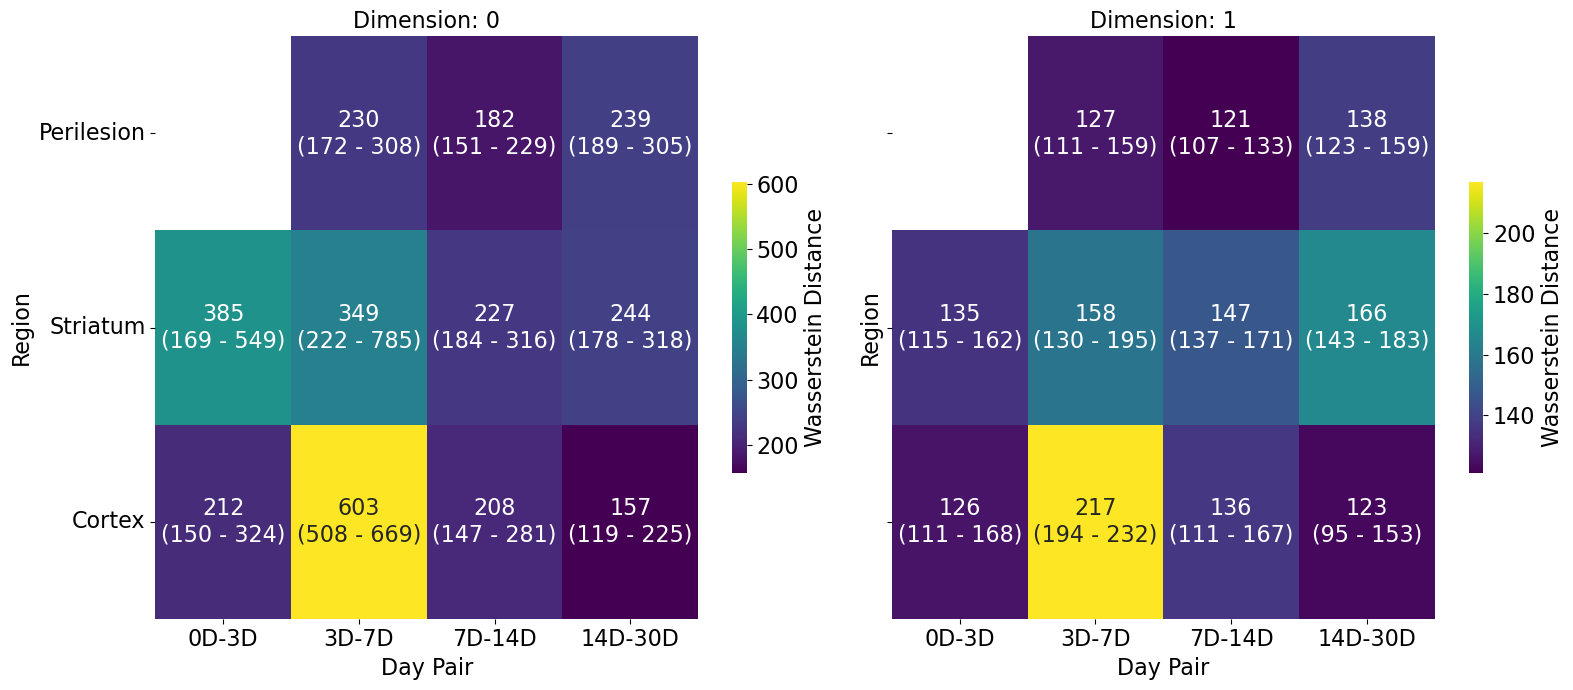

In [21]:
# Load CSV data for 0-dimension and 1-dimension homology
csv_path_dim0 = os.path.join("Data_Processed/Widefield_20x_ROIs_Pdgfrb/Widefield_20x_ROIs_Pdgfrb_Wasserstein_0d.csv")
csv_path_dim1 = os.path.join("Data_Processed/Widefield_20x_ROIs_Pdgfrb/Widefield_20x_ROIs_Pdgfrb_Wasserstein_1d.csv")
data_dim0 = pd.read_csv(csv_path_dim0)
data_dim1 = pd.read_csv(csv_path_dim1)

# Assuming the structure of your CSV files matches the expected columns

# Define label mappings and structure
regions = ["Peri", "Str", "Ctx"]
region_labels = ["Perilesion", "Striatum", "Cortex"]
days = ["0D-3D", "3D-7D", "7D-14D", "14D-30D"]
dimensions = ["dim0", "dim1"]  # Representing 0-dimension and 1-dimension homology

# Initialize an empty dictionary to store heatmap data for each dimension
heatmap_data = {dim: pd.DataFrame(index=regions, columns=days) for dim in dimensions}
heatmap_annotations = {dim: pd.DataFrame(index=regions, columns=days) for dim in dimensions}

# Function to populate matrices with data from CSV
def populate_heatmap(data, dim):
    for _, row in data.iterrows():
        day_pair, region, median_distance, lower, upper = row['Day1']+'-'+row['Day2'], row['Region'], round(row['Median Wasserstein Distance']), round(row['95% CI Lower']), round(row['95% CI Upper'])
        if region in regions:
            heatmap_data[dim].loc[region, day_pair] = median_distance
            # Adjust annotation format here to round and remove decimals
            annotation = f"{median_distance}\n({lower} - {upper})"
            heatmap_annotations[dim].loc[region, day_pair] = annotation

populate_heatmap(data_dim0, "dim0")
populate_heatmap(data_dim1, "dim1")

# Convert the data to numeric and handle NaN values
for dim in dimensions:
    heatmap_data[dim] = heatmap_data[dim].astype(float)
    heatmap_data[dim].fillna(-1, inplace=True)  # Fill NaN values with -1 for missing data

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
for ax, dim in zip(axes, dimensions):
    sns.heatmap(heatmap_data[dim], annot=heatmap_annotations[dim], cmap='viridis', ax=ax,
                cbar_kws={'label': 'Wasserstein Distance', 'shrink': 0.5},
                mask=(heatmap_data[dim] == -1), fmt="", annot_kws={"size": 16})
    ax.set_title(f"Dimension: {dim[-1]}", fontsize=16)
    ax.set_xlabel("Day Pair", fontsize=16)
    ax.set_ylabel("Region", fontsize=16)
    ax.set_yticklabels(region_labels, fontsize=16, rotation=0)
    ax.tick_params(axis='x', labelsize=16)

    # Adjust colorbar label size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_ylabel('Wasserstein Distance', fontsize=16)

plt.tight_layout()
plt.show()

# Update the output directory path for saving individual images
output_dir = "Plots/Widefield_20x_ROIs_pdgfrb_TDA"

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save individual heatmap images for each dimension
for dim in dimensions:
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(heatmap_data[dim], annot=heatmap_annotations[dim], cmap='viridis', ax=ax,
                cbar_kws={'label': 'Wasserstein Distance'},
                mask=(heatmap_data[dim] == -1), fmt="s")
    ax.set_title(f"Wasserstein Distances (Dimension: {dim[-1]})", fontsize=16)
    ax.set_xlabel("Day Pair", fontsize=16)
    ax.set_ylabel("Region", fontsize=16)
    ax.set_yticklabels(region_labels, fontsize=16)
    ax.tick_params(axis='x', labelsize=16)
    
    # Adjust colorbar label size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_ylabel('Wasserstein Distance', fontsize=16)
    
    plt.tight_layout()

    # Save the figure
    fig.savefig(os.path.join(output_dir, f"Wasserstein_Heatmap_{dim}.png"))
    plt.close(fig)


Analogous to Bottleneck distances, here we appreacite the estimates and its uncertainty for each day pair.

## Addon: Generate another set of images for illustration

Here, we create an additional visualization of Vietoris-rips complexes plotting the filtration circles at different values. We plot representative images and then store a full set of images in a designated location.

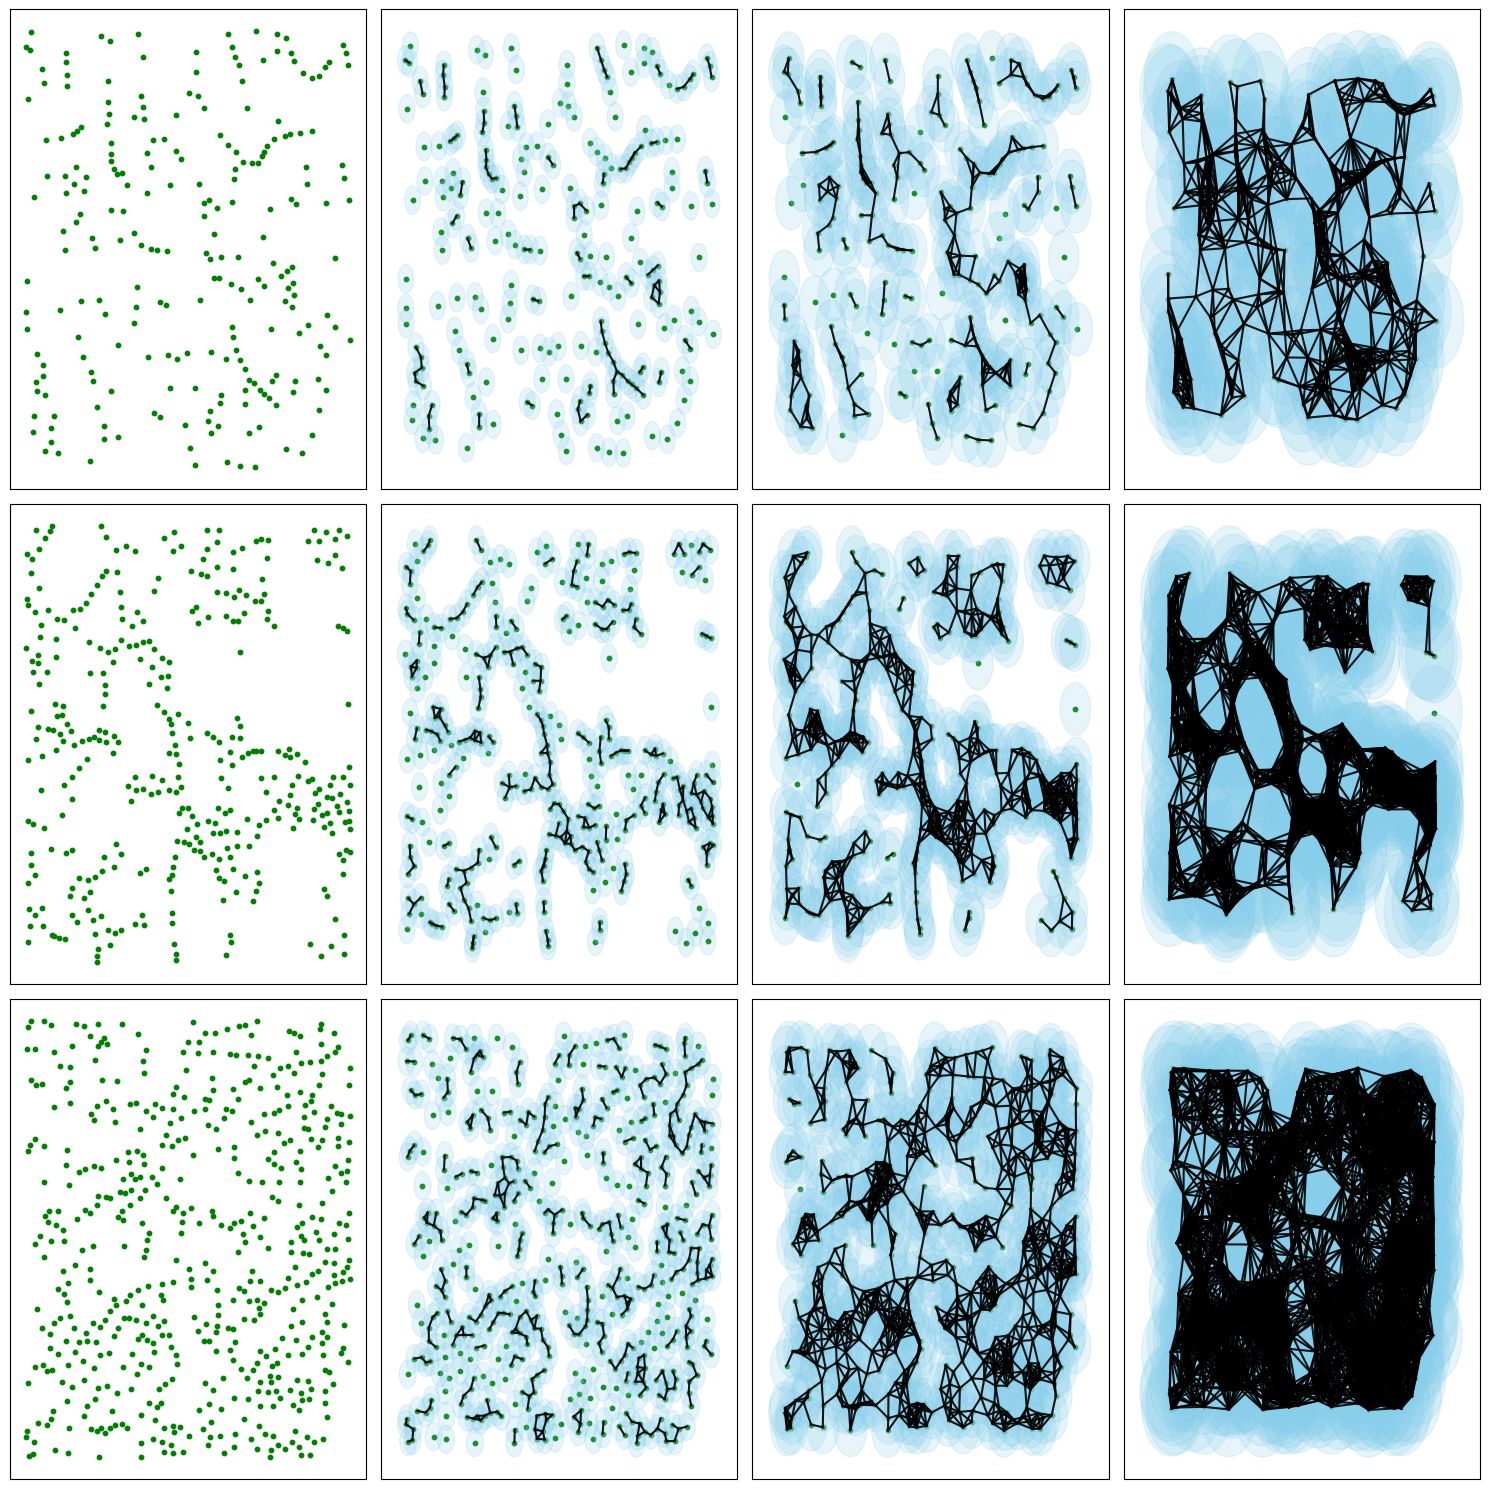

In [30]:
def load_point_cloud(file_path):
    return np.load(file_path, allow_pickle=True)

def get_edges_at_filtration(points, filtration_value):
    rips_complex = RipsComplex(points=points, max_edge_length=filtration_value)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
    
    edges = []
    for simplex, f_value in simplex_tree.get_filtration():
        if len(simplex) == 2 and f_value <= filtration_value:
            edges.append(simplex)
    
    return edges

def plot_point_cloud_with_structures(points, edges, ax, filtration_value):
    ax.scatter(points[:, 0], points[:, 1], color='green', s=10, zorder=1)
    for edge in edges:
        point1 = points[edge[0]]
        point2 = points[edge[1]]
        ax.plot([point1[0], point2[0]], [point1[1], point2[1]], 'black', alpha=0.9, zorder=1.5)
    for point in points:
        circle = Circle(point, radius=filtration_value, color='skyblue', fill=True, alpha=0.2)
        ax.add_patch(circle)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    
file_paths = ['PointClouds/Widefield_20x_ROIs_Pdgfrb/Td047_30D_Peri.npy', 
              'PointClouds/Widefield_20x_ROIs_Pdgfrb/Td047_30D_Str.npy', 
              'PointClouds/Widefield_20x_ROIs_Pdgfrb/Td047_30D_Ctx.npy']
filtration_values = [0, 50, 100, 200]

# Ensure each point cloud gets its subplot for each filtration value
fig, axs = plt.subplots(len(file_paths), len(filtration_values), figsize=(15, 5 * len(file_paths)))

for file_index, file_path in enumerate(file_paths):
    points = load_point_cloud(file_path)
    for ax_index, filtration_value in enumerate(filtration_values):
        ax = axs[file_index, ax_index] if len(file_paths) > 1 else axs[ax_index]
        edges = get_edges_at_filtration(points, filtration_value)
        plot_point_cloud_with_structures(points, edges, ax, filtration_value)

plt.tight_layout()
plt.show()


Finally, we save a series f images in a destinated folder for illustration in the scientific article. 

In [68]:
import os

# Load all .npy files in a folder
def load_point_clouds_from_folder(folder_path):
    point_cloud_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.npy')]
    return point_cloud_files

# Save the plot for a given point cloud and filtration values
def save_plots_for_point_cloud(file_path, filtration_values, save_folder):
    points = load_point_cloud(file_path)
    for filtration_value in filtration_values:
        edges = get_edges_at_filtration(points, filtration_value)
        
        fig, ax = plt.subplots(figsize=(5, 5))  # Adjust size as needed
        plot_point_cloud_with_structures(points, edges, ax, filtration_value)
        
        # Save plot to the designated folder
        base_filename = os.path.splitext(os.path.basename(file_path))[0]
        save_path = os.path.join(save_folder, f'{base_filename}_filtration_{filtration_value}.png')
        plt.savefig(save_path)
        plt.close(fig)  # Close the figure after saving to free up memory

# Specify folder paths
point_clouds_folder = 'PointClouds/Widefield_20x_ROIs_Pdgfrb/'
save_folder = 'D:/Research/Stroke_PDGFR-B_Reactivity/Images/Widefield_20x-ROIs_Pdgfrb_TDA/FiltrationValues'
filtration_values = [0, 50, 100, 200]

# Ensure the save folder exists
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Load and process each point cloud file
point_cloud_files = load_point_clouds_from_folder(point_clouds_folder)
for file_path in point_cloud_files:
    save_plots_for_point_cloud(file_path, filtration_values, save_folder)
